<a href="https://colab.research.google.com/github/hernandezhdd/TrabajosMachineLearning/blob/master/TP-Final-Transfer-Learning/Final_ML_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


@title MIT License

Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.


# Trabajo Final de *Machine Learning*: *Transfer Learning* con las redes neuronales MobileNetV3 y EfficientNetB0


### Fuente

Esta notebook está parcialmente basada en el tutorial de TensorFlow:

https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb


### Contenidos

1. [Data Preprocessing](#1)
1. [Feature extraction](#2)
1. [Fine tuning](#3)
1. [Analisis de predicciones y errores](#4)
1. [EfficientNetB0 o ResNet50V2](#5)
1. [Funcion para definir el modelo](#6)

## Introducción

Tranfer Learning es la práctica de utilizar modelos pre-entrenados para resolver un problema nuevo y distinto al original, pero del mismo tipo. En este trabajo se utilizará un clasificador de imagenes pre-entrenado con un cierto dataset y ciertas categorías, para clasificar imágenes de un dataset desconocido por el modelo, y con categorías distintas al dataset original.

De manera simple, el fundamento consiste en que las primeras capas de la red neuronal contienen información sobre como discernir distintas características de una imagen u objeto, por lo que resultan útiles para otras tareas de reconocimiento de imágenes.

Una ventaja de este método es que permite ahorrar mucho tiempo y recursos en entrenar buena parte de las capas del modelo. Una segunda ventaja es que permite utilizar pesos entrenados con un dataset probablemente mucho mas grande que el propio. Esto permite utilizar redes neuronales mucho mas profundas que lo que hubiera sido posible con el dataset propio, sin caer en overfitting. Los pesos que se utilizarán fueron obtenidos con el conocido dataset ImageNet, un dataset con mas de 10 millones de imágenes. 

Primero se probara la red sin reentrenarla, sólo cambiando el clasificador en la ultima capa. Luego se permitira que las ultimas capas de la red tengan un reentrenamiento, para que aprendan sobre la tarea nueva. Es necesario tener en cuenta que antes de empezar a reentrenar las capas, se debe haber entrenado primero el clasificador final.

Como el dataset que se utilizara es mucho menor al dataset original, sólo se puede reentrenar una parte de la red. Si se quiere reentrenar todos los parámetros habrá *overfitting*.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.8.0


<a name='1'></a>
## Data preprocessing

### Descarga del dataset

Se usará un dataset de imagenes que se encuentra en  [*kaggle*](https://www.kaggle.com/datasets/l3llff/flowers). El dataset se puede descargar usando la API de *kaggle*, o desde un link en Google Drive en la siguiente sección. 

Para descargarlo desde Kaggle es necesario poseer un usuario y API key.

### Kaggle

In [ ]:
# !pip install kaggle

In [ ]:
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json

# api_token = {"username":"USERNAME","key":"API_KEY"}

# import json

# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# import kaggle

# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('l3llff/flowers', path='flowers_dataset', unzip=True)

###Para descargar el dataset desde Google Drive

Link al dataset

https://drive.google.com/file/d/1ZhxQu6LTM4AobbjJMMsSYOgW6CmtottZ/view?usp=sharing




In [ ]:
import gdown

!mkdir /content/flowers_dataset

output = "/content/flowers_dataset/Flowers_Dataset.zip"
gdown.download(id='1ZhxQu6LTM4AobbjJMMsSYOgW6CmtottZ', output=output, quiet=False)

mkdir: cannot create directory ‘/content/flowers_dataset’: File exists


Downloading...
From: https://drive.google.com/uc?id=1ZhxQu6LTM4AobbjJMMsSYOgW6CmtottZ
To: /content/flowers_dataset/Flowers_Dataset.zip
100%|██████████| 216M/216M [00:01<00:00, 194MB/s]


'/content/flowers_dataset/Flowers_Dataset.zip'

In [ ]:
!unzip -q -u /content/flowers_dataset/Flowers_Dataset.zip -d /content/flowers_dataset

### Construccion del dataset

La descarga tiene trece carpetas, una por cada categoría. Luego se construye el dataset utilizando la herramienta `tf.keras.utils.image_dataset_from_directory`.

Se utilizara 20% de las imágenes como validación. 

#### Uso de la funcion `image_dataset_from_directory`

La función toma como argumentos: 

- `directory`: el directorio donde se encuentra el dataset.
- `shuffle`: para barajar las imagenes.
- `batch_size`: cuantas imagenes se toman a la vez.                     
- `image_size`: tamaño de las imágenes.
- `validation_split`: fracción de las imágenes para utilizar como validación.
- `subset`: subconjunto del dataset que será esta variable.
- `seed`: semilla para obtener siempre la misma aleatorización.
- `labels`: para determinar la etiqueta de cada imágen. El argumento `inferred` es necesario para que la función devuelva las etiquetas.
- `label_mode`: modo de la etiqueta.

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (256, 256)
directory = "/content/flowers_dataset/flowers/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=21,
                                             labels='inferred', # Agrego esto
                                             # debido a que trabajo con 
                                             # mas de una clase
                                             label_mode='categorical') # Agrego esto

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=21,
                                             labels='inferred', # Agrego esto
                                             label_mode='categorical') # Agrego esto

Found 13838 files belonging to 14 classes.
Using 11071 files for training.
Found 13838 files belonging to 14 classes.
Using 2767 files for validation.


La siguiente celda muestra el tipo de variable que es `validation_dataset`. Contiene las imagenes de tamaño (256, 256, 3), y las correspondientes etiquetas, como vector de *one_hot_encoding*, de tamaño (1,13).

In [ ]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

Las clases de las flores se pueden ver con el atributo `class_names` 

In [ ]:
train_dataset.class_names

['astilbe',
 'bellflower',
 'black-eyed susan',
 'calendula',
 'california poppy',
 'carnation',
 'common daisy',
 'coreopsis',
 'dandelion',
 'iris',
 'rose',
 'sunflower',
 'tulip',
 'water lily']

#### Imágenes de ejemplo

In [ ]:
# class_names[tf.where(predictions[i]).numpy()[0][0]]
# tf.where(labels[i]).numpy()[0][0]

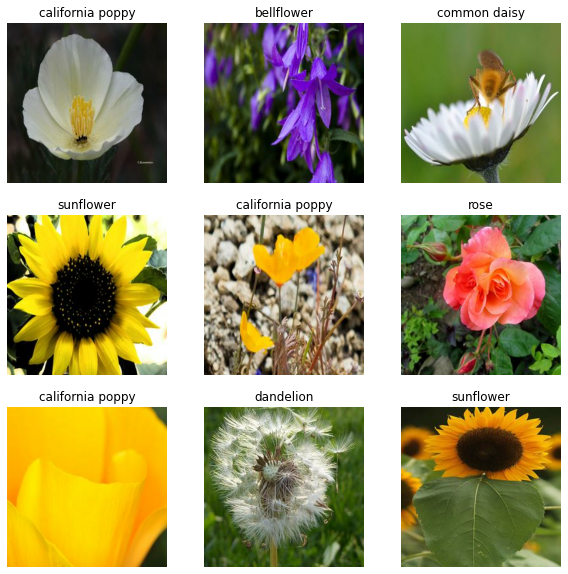

In [ ]:
import matplotlib.pyplot as plt 

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    mask = tf.where(labels[i]).numpy()[0][0]
    plt.title(class_names[mask])
    plt.axis("off")

Es recomendable tener un dataset de testing, para ello se puede dividir `validation_dataset`, en validacion y testing. Para averiguar  la cantidad de batches en ese dataset, se puede utilizar la función `tf.data.experimental.cardinality`. Luego se puede crear `test_dataset` utilizando 20% de los datos de validacion.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 70
Number of test batches: 17


### Uso de *buffering*

Se puede utilizar *buffered prefetching* para cargar de antemano las imágenes del disco. Esto evita tener problemas de rendimiento debido a un cuello de botella en la velocidad del disco. Mas informacion en la guía de rendimiento, [data performance](https://www.tensorflow.org/guide/data_performance).

Usando `prefetch()` se toman algunas imágenes y se preparan para el momento de utilizarlas. Este proceso es continuo, y de este modo se evita tener que cargar todas las imágenes en memoria.

Original:

> Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### *Data augmentation*

Una técnica útil cuando se tiene un dataset de tamaño pequeño o medio es *data augmentation*. Ésta consiste en aumentar la cantidad de imágenes en el dataset, tomando las imágenes originales y aplicándoles dos operaciones. Se suelen aplicar rotaciones con un ángulo aleatorio, lo cual provee *nuevas* imágenes que ayudan a reconocer el mismo objeto desde otro ángulo. También se suelen voltear horizontalmente las imágenes, para obtenersu versión espejada. 

Estas técnicas son útiles para reducir el *overfitting*.

Original:

> When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

La siguiente celda crea  dos capas utilizando  la función `tf.keras.Sequential`. La primera capaz voltea aleatoriamente las imágenes. La segunda capa rota aleatoriamente las imágenes. El argumento en la función llamado *factor*. En este caso representa el ángulo mínimo y máximo que pueden tomar las rotaciones, como fracción de $2 \pi$. 

$$ 0.2 \cdot 2 \pi = 72º $$

Por lo tanto las rotaciones serán en el intervalo $ [-72º, 72º] $.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Nota: éstas capas sólo están activas durante el entrenamiento, cuando `Model.fit` es llamado. Cuando el modelo es utilizado en modo de inferencia se desactivan. Puede ser en `Model.evaluate` o `Model.fit`.

Original:

> Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Prueba del método en una misma imágen.

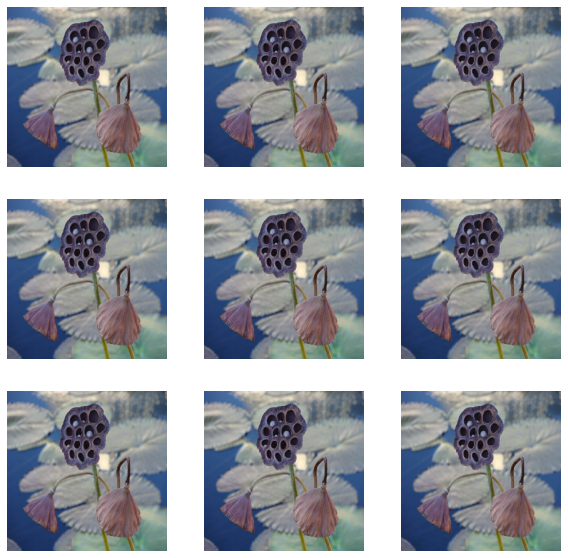

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Normalización de los *pixeles*

El modelo `tf.keras.applications.MobileNetV2` utiliza los *pixeles* normalizados al intervalo `[-1, 1]`. Para normalizar las imágenes se puede usar la herramienta `tf.keras.applications.mobilenet_v2.preprocess_input` incluída con el modelo `mobilenet_v2`. En la siguiente celda se instancia la capa `preprocess_input`.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Alternativamente se podría haber hecho manualmente con la función `tf.keras.layers.Rescaling`.

In [ ]:
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Nota: al utilizar otros modelos de `tf.keras.applications`, es recomendable consultar la documentacion de la API, para determinar el rango de valores esperado por el modelo.

Original
> Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

<a name='2'></a>
## Feature extraction

### MobileNetV2

La red MobileNetV2 está optimizada para ser utilizada en celulares y otros dispositivos poco potentes. Tiene 150 capas entre las cuales tiene:

*   Convoluciones separables
*   Capas de cuello de botella
*   Conexiones residuales entre capas

<img src="https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png">

### Creación del modelo base utilizando pesos pre-entrenados 

El modelo base será una copia de la red **MobileNet V3**, la cual fue entrenada en el dataset ImageNet, utilizando mas de 1 millón de imágenes, y mil clases. Este dataset tiene gran variedad de clases, y tiene un propósito más genérico que nuestro dataset de flores.

El procedimiento en esta primera etapa, será utilizar toda la red **MobileNet V3**, excepto por la última capa. La idea es utilizar todo el conocimiento de la red original, pero cambiar el clasificador, y entrenarlo para que reconozca los trece tipos de flores. 

Para ello, se instancia el modelo **MobileNet V2** con los pesos pre-entrenados. Utilizando el argumento `include_top=False`, se especifica que la última capa no sea incluída. El tamaño de las imágenes a clasificar en el estandar *(ancho, alto, canales)* es pasado con `input_shape`. Los pesos de la red se especifican con `weigths`. En este caso se elijen los pesos entrenados en el dataset `imagenet`

In [ ]:
# # Create the base model from the pre-trained model MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=False
                                               )

12697600/12683000 [==============================] - 0s 0us/step


La *warning* será ignorada ya que parece que MobileNetV2 debería funcionar igual:

https://stackoverflow.com/questions/55571664/mobilenets-for-a-custom-image-size

El modelo base convierte las imágenes de *(256,256,3)*, en bloques de *(8,8,1280)*

En el siguiente batch de 32 imágenes se obtiene:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 960)


### *Freezing*

En esta etapa se congela la base convolucional. Esto hace que sólo los pesos de la última capa sean cambiados en el entrenamiento.

### Congelar la base convolucional

Para congelar una capa se utiliza el atributo `layer.trainable`. Utilizando `base_model.trainable = False`
se congelan todas las capas de la red.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 128, 128, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                  


### Creacion del clasificador

Para hacer las predicciones primero se puede pasar la salida del modelo base por una capa `tf.keras.layers.GlobalAveragePooling2D`, conviertiendo las *features* en vectores.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


Luego se aplica una capa `tf.keras.layers.Dense` para hacer las predicciones. La función de activación es *softmax* para clasificación múltiple.

In [ ]:
# Tipos de flores
NUM_CLASSES = 14

prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 14)


Luego se encadenan todas las etapas.

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compilación del modelo

Se compila el modelo, y luego se entrena. Se cambió  `from_logits=False`, ya que ahora antes de esa funcion hay una activación `softmax`.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                             

Hay 3 millones de parámetros de la red MobileNetV3 congelados, y hay 13000 parámetros entrenables que pertenecen a la capa *Dense* agregada.

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.trainable_variables #shape=(1280, 14)

[<tf.Variable 'dense/kernel:0' shape=(960, 14) dtype=float32, numpy=
 array([[-0.00981145, -0.02228283, -0.0569936 , ...,  0.07825233,
          0.0031589 ,  0.05067855],
        [ 0.00327974,  0.03266485,  0.06253971, ...,  0.07271017,
         -0.05522399,  0.03055956],
        [ 0.01703838, -0.0045179 , -0.04393859, ..., -0.03589457,
          0.00672087, -0.05187397],
        ...,
        [-0.03249571, -0.07310889,  0.05406788, ..., -0.0127105 ,
          0.0185038 , -0.01562171],
        [-0.06686602, -0.07499253, -0.00996793, ..., -0.02704743,
         -0.05387436, -0.04035953],
        [-0.06565162, -0.07057639,  0.00238254, ..., -0.05884372,
         -0.03049573,  0.0496095 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(14,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>]

### Entrenamiento del modelo


In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

70/70 [==============================] - 12s 103ms/step - loss: 3.2960 - accuracy: 0.0463


In [ ]:
print(f"initial loss: {loss0:.2f}")
print(f"initial accuracy: {accuracy0:.2f}")

initial loss: 3.30
initial accuracy: 0.05


In [ ]:
initial_epochs = 8

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/8
346/346 [==============================] - 53s 137ms/step - loss: 2.3387 - accuracy: 0.2471 - val_loss: 1.4980 - val_accuracy: 0.5731
Epoch 2/8
346/346 [==============================] - 44s 126ms/step - loss: 1.3606 - accuracy: 0.5886 - val_loss: 0.9781 - val_accuracy: 0.7638
Epoch 3/8
346/346 [==============================] - 44s 127ms/step - loss: 0.9880 - accuracy: 0.7242 - val_loss: 0.7452 - val_accuracy: 0.8183
Epoch 4/8
346/346 [==============================] - 44s 126ms/step - loss: 0.7993 - accuracy: 0.7798 - val_loss: 0.6203 - val_accuracy: 0.8466
Epoch 5/8
346/346 [==============================] - 44s 126ms/step - loss: 0.6878 - accuracy: 0.8078 - val_loss: 0.5435 - val_accuracy: 0.8632
Epoch 6/8
346/346 [==============================] - 44s 127ms/step - loss: 0.6080 - accuracy: 0.8338 - val_loss: 0.4867 - val_accuracy: 0.8763
Epoch 7/8
346/346 [==============================] - 44s 125ms/step - loss: 0.5576 - accuracy: 0.8417 - val_loss: 0.4472 - val_accuracy:

### Curvas de aprendizaje


In [ ]:
acc=0
val_acc = 0

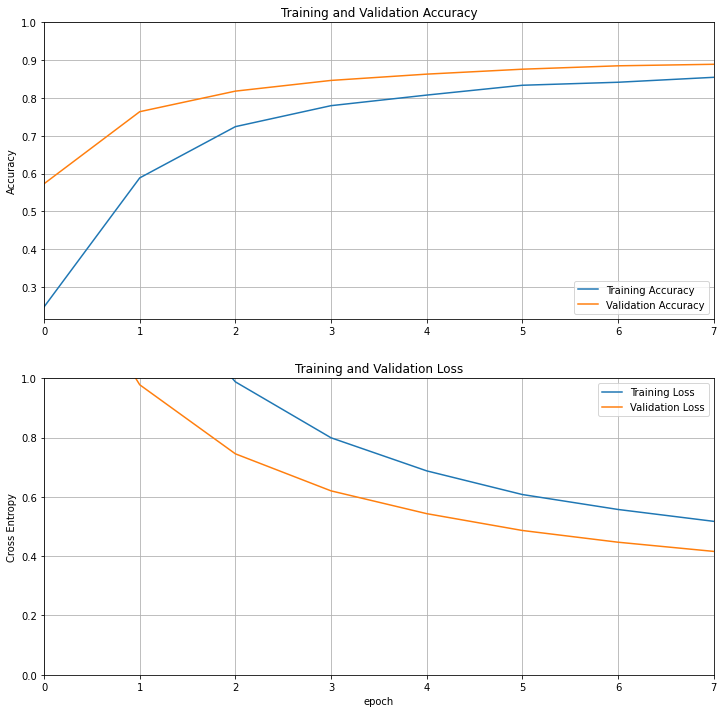

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlim([0,initial_epochs-1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.xlim([0,initial_epochs-1])

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

<a name='3'></a>
## Fine tuning

Luego se pueden entrenar (*fine-tune*) los pesos de las ultimas capas del modelo base, para aprender *features* específicos del *dataset*.

Nota: Esto sólo se debe hacer luego de haber entrenado el clasificador. De lo contrario, la magnitud de las actualizaciones de los gradientes van a ser demasiado grandes, lo que hará que el modelo olvide la información anterior.

Ademas no se debe intentar reentrenar todas las capas del modelo, sólo las últimas que tienen que ver con *features* más especificas. Por otro lado, una red tan compleja se va a sobre adaptar rápidamente a un dataset pequeño. 

Original:

>Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

>Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.


### *Un-freezeing* las últimas capas 


Se deben configurar el modelo entero como *trainable* y luego volver a congelar las primeras capas.

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

base_model.layers[0]

Number of layers in the base model:  262


In [ ]:
# Fine-tune desde aca en adelante
fine_tune_at = 160

base_model.trainable = True

# Freeze todas las capas anteriores a fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the model

Es necesario recompilar el modelo y utilizar un *learning rate* mas bajo.

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                             

In [ ]:
len(model.trainable_variables)

60

### Reanudacion del entrenamiento

In [ ]:
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 8/15
346/346 [==============================] - 79s 202ms/step - loss: 0.3644 - accuracy: 0.8914 - val_loss: 0.2769 - val_accuracy: 0.9150
Epoch 9/15
346/346 [==============================] - 69s 197ms/step - loss: 0.2946 - accuracy: 0.9091 - val_loss: 0.2535 - val_accuracy: 0.9222
Epoch 10/15
346/346 [==============================] - 69s 197ms/step - loss: 0.2548 - accuracy: 0.9192 - val_loss: 0.2290 - val_accuracy: 0.9267
Epoch 11/15
346/346 [==============================] - 68s 197ms/step - loss: 0.2336 - accuracy: 0.9267 - val_loss: 0.2115 - val_accuracy: 0.9343
Epoch 12/15
346/346 [==============================] - 69s 198ms/step - loss: 0.2161 - accuracy: 0.9318 - val_loss: 0.2062 - val_accuracy: 0.9357
Epoch 13/15
346/346 [==============================] - 69s 197ms/step - loss: 0.1912 - accuracy: 0.9407 - val_loss: 0.2061 - val_accuracy: 0.9343
Epoch 14/15
346/346 [==============================] - 69s 198ms/step - loss: 0.1759 - accuracy: 0.9438 - val_loss: 0.1977 - v

En las curvas de aprendizaje se observa que luego de *fine-tuning* se mejora la precision en el dataset de validacion en 5%. También se observa un poco de *overfitting* debido a que el dataset es pequeño. Por ello no sería útil seguir entrenando la red, sólo se lograría mas *overfitting*.


Luego del *fine-tuning* se obtiene alrededor de 94% de precisión.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

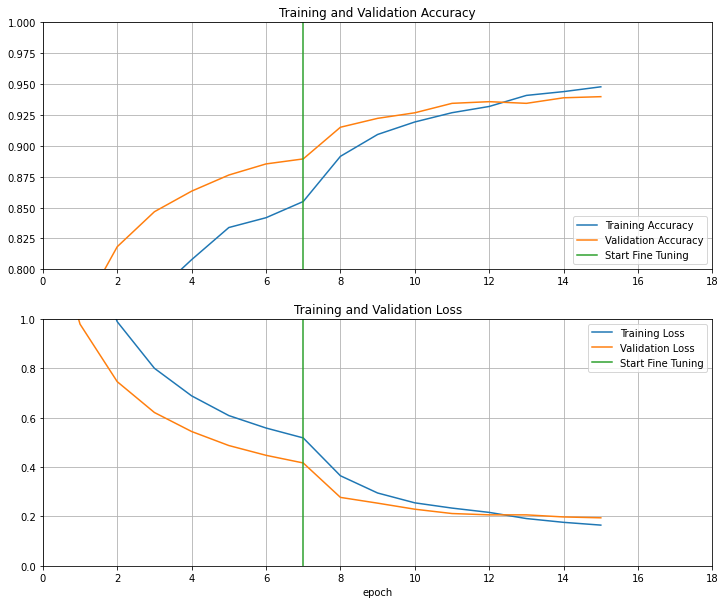

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.xlim([0, 18])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.xlim([0, 18])

plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.grid()
plt.show()

### Evaluacion y prediccion

Se puede verificar el desempeño del modelo en el dataset de `testing`.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 2s 100ms/step - loss: 0.1703 - accuracy: 0.9412
Test accuracy : 0.9411764740943909


<a name='4'></a>
## Analisis de predicciones y errores

Lo siguiente es revisar las imágenes donde el modelo predice mal en el dataset de *testing*. Tambien se puede hacer con el resto de los *dataset*.

In [ ]:
image_batch = np.ndarray((0,256,256,3))
label_batch = np.ndarray((0,14))

# Esto no es optimo pero no se hacerlo mejor en tf
for i in range(tf.data.experimental.cardinality(test_dataset)):

  temp_image_batch, temp_label_batch = test_dataset.as_numpy_iterator().next()
  # temp_predictions = model.predict_on_batch(temp_image_batch)

  image_batch = np.concatenate((image_batch, temp_image_batch), axis=0)
  label_batch = np.concatenate((label_batch, temp_label_batch), axis=0)

In [ ]:
predictions = model.predict_on_batch(image_batch)

In [ ]:
image_batch.shape, label_batch.shape, 32*17

((544, 256, 256, 3), (544, 14), 544)

### Comparacion de las etiquetas con las predicciones

Esto se debe poder hacer con el framework de tf, pero usar pandas me resulta mas conocido.

In [ ]:
import pandas as pd

# Las clases son las columnas
pred_df = pd.DataFrame(predictions)
# Indice del maximo de cada prediccion
pred_labels = pred_df.idxmax(axis=1)
# Las clases son las columnas
label_df = pd.DataFrame(label_batch)
# Indice del 1 de cada etiqueta
labels = label_df.idxmax(axis=1)
# Comparo los arrays etiquetas y predicciones
mask = (labels!=pred_labels)
# Esta mascara tiene los índices donde el modelo
# predice mal
mask = np.where(mask)[0]

In [ ]:
# Predicciones para la imagen 12
predictions[12]

array([2.5471749e-07, 3.6130598e-07, 9.9761718e-12, 6.8841018e-06,
       5.2678817e-09, 6.3866480e-07, 7.1678380e-07, 1.1615852e-09,
       3.0675679e-10, 1.8613255e-07, 1.9434572e-09, 5.1583342e-08,
       7.3733595e-08, 9.9999082e-01], dtype=float32)

In [ ]:
# Etiqueta para la imagen 12
label_batch[12]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

### Gráfico de varias imágenes con su prediccion

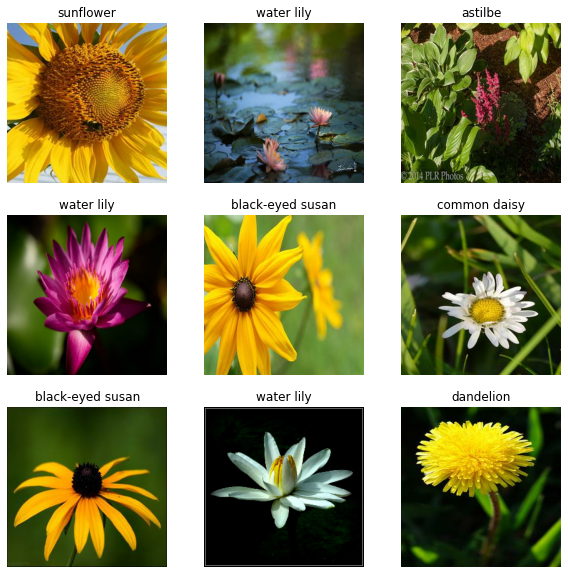

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_labels[i]])
  plt.axis("off")

#### Hay 19 errores en el dataset de testing

In [ ]:
mask.shape

(19,)

In [ ]:
mask

array([ 21,  28,  58,  96, 141, 182, 230, 240, 272, 305, 338, 342, 420,
       421, 501, 504, 520, 526, 542])

### Grafico de las imágenes donde el modelo erra en el dataset de *testing*. 

Hay unas cuantas imágenes duplicadas, no encuentro la razon.

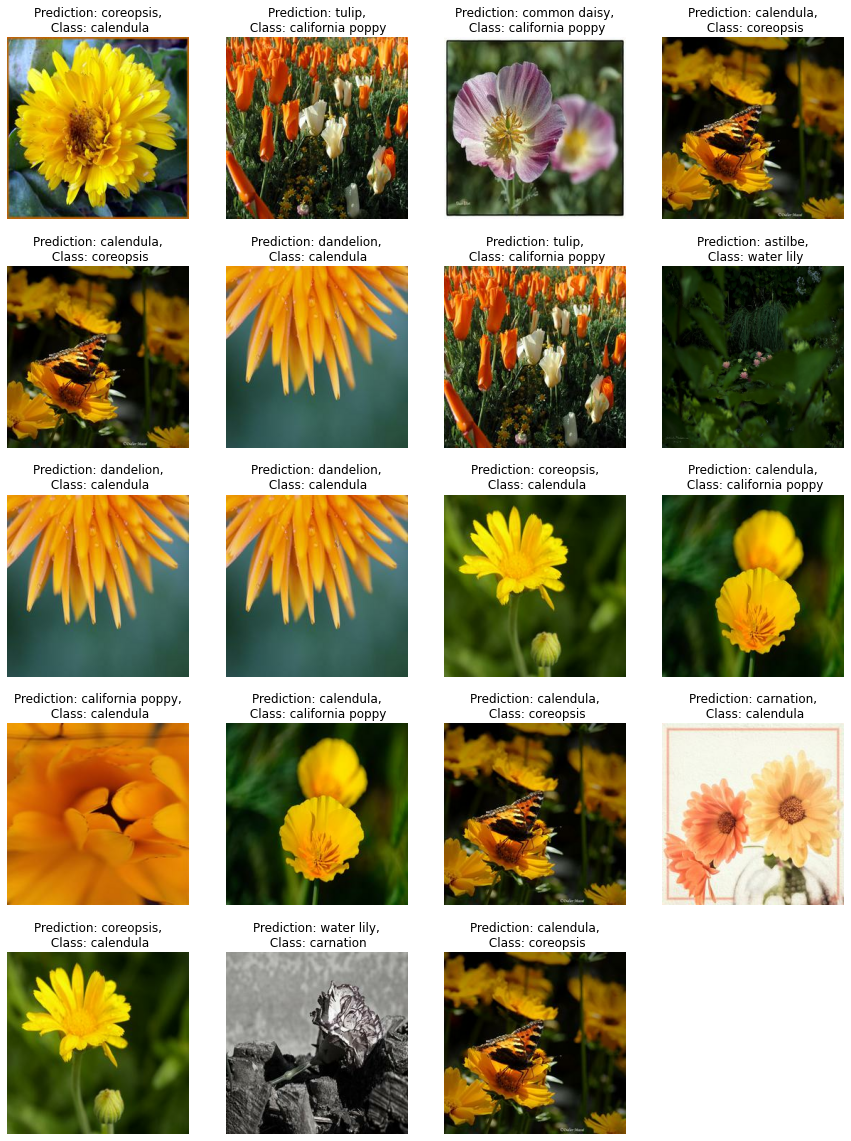

In [ ]:
plt.figure(figsize=(15, 75))
j=0
for i in mask:
  
  ax = plt.subplot(18, 4, j + 1)
  plt.imshow(image_batch[i,:,:,:].astype("uint8"))
# plt.imshow(np.squeeze(image_batch[mask][:, :, :,0]).astype("uint8"))
  plt.title(f'Prediction: {class_names[pred_labels[i]]},\n Class: {class_names[labels[i]]}')
  plt.axis("off")
  j=j+1

<a name='6'></a>
## Funcion para crear un modelo

Se puede definir una función con todos los pasos para poder instanciar el modelo en una sóla celda.

In [ ]:
def Flores_MobileNet(image_shape=IMG_SIZE, data_augmentation=data_augmentation, fine_tune_at=-1):
    ''' Modelo de tf.keras para clasificacion múltiple basado en MobileNetV3Large.
    La feature de fine-tuning aun no funciona. Falta poder pasar la capa final entrenada.
    Argumentos:
        image_shape -- Ancho y alto de la imagen
        data_augmentation -- Funcion de data augmentation
    Retorna:
        tf.keras.model
    '''
    
    import tensorflow as tf

    # Tipos de flores
    NUM_CLASSES = 14

    # Create the base model from the pre-trained model MobileNet V3
    IMG_SHAPE = IMG_SIZE + (3,)

    base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True
                                               )
    
    # Para congelar una capa se utiliza el atributo `layer.trainable`.
    # Utilizando `base_model.trainable = False`
    # se congelan todas las capas de la red.

    if fine_tune_at == -1:
      base_model.trainable = False
    else:
      base_model.trainable = True

      # Fine-tune from this layer onwards
      # fine_tune_at

      # Freeze all the layers before the `fine_tune_at` layer
      for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False


    # To generate predictions from the block of features, average over the
    # spatial 5x5 spatial locations, using a 
    # tf.keras.layers.GlobalAveragePooling2D layer to convert
    # the features to a single 1280-element vector per image.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    # Capa de prediccion con una neurona por cada tipo de flor
    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

    # Se instancia la capa de entrada
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    
    # La siguiente capa aplica data augmentation a las inputs
    x = data_augmentation(inputs)

    # Data preprocessing (no usado ya que MobileNetV3Large
    # tiene include_preprocessing=False)
    # x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    # training=False para evitar problemas con las capas de BatchNorm
    x = base_model(x, training=False)   

    x = global_average_layer(x)

    # Se usa dropout con probabilidad de 0.2 para evitar overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    outputs = prediction_layer(x)
    
    modelo = tf.keras.Model(inputs, outputs)
    
    return modelo, base_model

Create your new model using the data_augmentation function defined earlier.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
IMG_SIZE = (256,256)

modelo, modelo_base = Flores_MobileNet(image_shape=IMG_SIZE, data_augmentation=data_augmentation)

The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [ ]:
base_learning_rate = 0.0001
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = modelo.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

<a name='5'></a>
## EfficientNetV2B0 o ResNet50V2

Luego se puede probar otro de los modelos que hay en Keras.

In [ ]:
def Flores_EfficientNet(image_shape=IMG_SIZE, data_augmentation=data_augmentation, fine_tune_at=-1):
    ''' Modelo de tf.keras para clasificacion múltiple basado en EfficientNetB0.
    La feature de fine-tuning aun no funciona. Falta poder pasar la capa final entrenada.
    Argumentos:
        image_shape -- Ancho y alto de la imagen
        data_augmentation -- Funcion de data augmentation
    Retorna:
        tf.keras.model
    '''
    
    import tensorflow as tf

    # Tipos de flores
    NUM_CLASSES = 14

    # Create the base model from the pre-trained model MobileNet V3
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               include_preprocessing=True
                                               )
    
    # Para congelar una capa se utiliza el atributo `layer.trainable`.
    # Utilizando `base_model.trainable = False`
    # se congelan todas las capas de la red.
    
    if fine_tune_at == -1:
      base_model.trainable = False
    else:
      base_model.trainable = True
      # Fine-tune from this layer onwards
      # fine_tune_at 
      # Freeze all the layers before the `fine_tune_at` layer
      for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # To generate predictions from the block of features, average over the
    # spatial 5x5 spatial locations, using a 
    # tf.keras.layers.GlobalAveragePooling2D layer to convert
    # the features to a single 1280-element vector per image.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    # Capa de prediccion con una neurona por cada tipo de flor
    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

    # Se instancia la capa de entrada
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    
    # La siguiente capa aplica data augmentation a las inputs
    x = data_augmentation(inputs)

    # Data preprocessing (no usado ya que MobileNetV3Large
    # tiene include_preprocessing=False)
    # x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    # training=False para evitar problemas con las capas de BatchNorm
    x = base_model(x, training=False)   

    x = global_average_layer(x)

    # Se usa dropout con probabilidad de 0.2 para evitar overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    outputs = prediction_layer(x)
    
    modelo = tf.keras.Model(inputs, outputs)
    
    return modelo, base_model

In [ ]:
def Flores_ResNet50V2(image_shape=IMG_SIZE, data_augmentation=data_augmentation, fine_tune_model= fine_tune_at=-1):
    ''' Modelo de tf.keras para clasificacion múltiple basado en EfficientNetB0.
    La feature de fine-tuning aun no funciona. Falta poder pasar la capa final entrenada.
    Argumentos:
        image_shape -- Ancho y alto de la imagen
        data_augmentation -- Funcion de data augmentation
    Retorna:
        tf.keras.model
    '''
    
    import tensorflow as tf

    # Tipos de flores
    NUM_CLASSES = 14

    # Create the base model from the pre-trained model MobileNet V3
    IMG_SHAPE = IMG_SIZE + (3,)
    
    base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  
    # Para congelar una capa se utiliza el atributo `layer.trainable`.
    # Utilizando `base_model.trainable = False`
    # se congelan todas las capas de la red.
    
    if fine_tune_at == -1:
      base_model.trainable = False
    else:
      base_model.trainable = True

      # Fine-tune from this layer onwards
      # fine_tune_at

      # Freeze all the layers before the `fine_tune_at` layer
      for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

    # To generate predictions from the block of features, average over the
    # spatial 5x5 spatial locations, using a 
    # tf.keras.layers.GlobalAveragePooling2D layer to convert
    # the features to a single 1280-element vector per image.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    # Capa de prediccion con una neurona por cada tipo de flor
    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

    # Se instancia la capa de entrada
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    
    # La siguiente capa aplica data augmentation a las inputs
    x = data_augmentation(inputs)

    # Data preprocessing
    x = preprocess_input(x)

    # training=False para evitar problemas con las capas de BatchNorm
    x = base_model(x, training=False)   

    x = global_average_layer(x)

    # Se usa dropout con probabilidad de 0.2 para evitar overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    outputs = prediction_layer(x)
    
    modelo = tf.keras.Model(inputs, outputs)
    
    return modelo, base_model

Create your new model using the data_augmentation function defined earlier.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
IMG_SIZE = (256,256)

model2, base_model2 = Flores_EfficientNet(image_shape=IMG_SIZE, data_augmentation=data_augmentation)

In [ ]:
# Let's take a look at the base model architecture
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 14)                1793

### Complejidad 
Se observa que ResNet50V2 posee mas de veinte millones de parámetros entrenables, mientras que MobileNetV2 poseía alrededor de diez veces menos.

EfficientNetV2B0 tiene 6 millones de parámetros en comparación.

The 6 million parameters in EfficientNetB0 are frozen, but there are 18 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Entrenamiento del modelo



In [ ]:
loss0, accuracy0 = model2.evaluate(validation_dataset)

70/70 [==============================] - 15s 141ms/step - loss: 2.7912 - accuracy: 0.0445


In [ ]:
print(f"initial loss: {loss0:.2f}")
print(f"initial accuracy: {accuracy0:.2f}")

initial loss: 2.79
initial accuracy: 0.04


In [ ]:
initial_epochs = 5

history = model2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

346/346 [==============================] - 71s 179ms/step - loss: 2.0814 - accuracy: 0.4122 - val_loss: 1.5618 - val_accuracy: 0.6824


### Curvas de aprendizaje


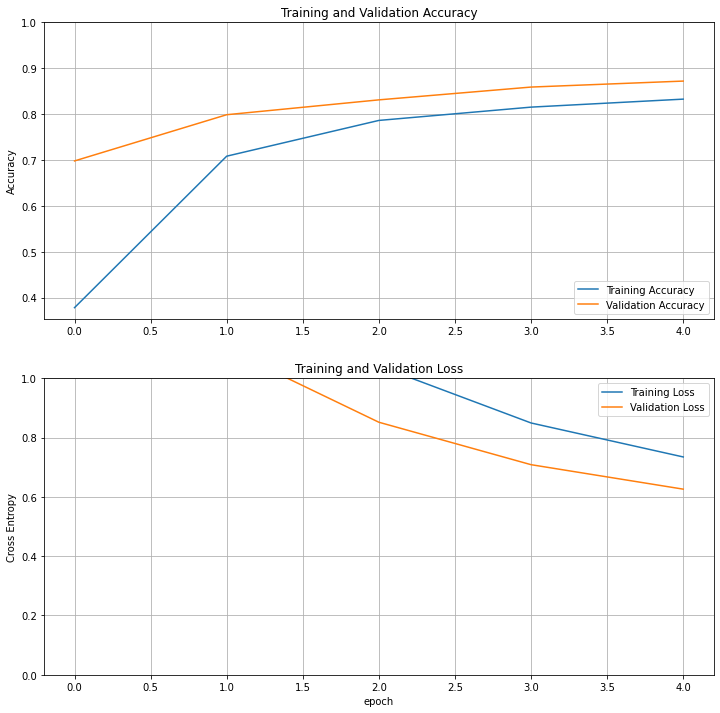

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model2.layers))

base_model2.layers[0]

Number of layers in the base model:  255


In [ ]:
# Fine-tune desde aca en adelante
fine_tune_at = 210

base_model2.trainable = True

# Freeze todas las capas anteriores a fine_tune_at
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# IMG_SIZE = (256,256)

# model2, base_model2 = Flores_EfficientNet(image_shape=IMG_SIZE,
#                                           data_augmentation=data_augmentation,
#                                           fine_tune_at=fine_tune_at)

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 14)                1793

In [ ]:
len(model2.trainable_variables)

44

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/6
346/346 [==============================] - 87s 220ms/step - loss: 1.0782 - accuracy: 0.7307 - val_loss: 0.6681 - val_accuracy: 0.8246
Epoch 2/6
346/346 [==============================] - 75s 216ms/step - loss: 0.6474 - accuracy: 0.8086 - val_loss: 0.4701 - val_accuracy: 0.8592
Epoch 3/6
346/346 [==============================] - 74s 212ms/step - loss: 0.4919 - accuracy: 0.8472 - val_loss: 0.3819 - val_accuracy: 0.8857
Epoch 4/6
108/346 [========>.....................] - ETA: 45s - loss: 0.4523 - accuracy: 0.8571

KeyboardInterrupt: ignored

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the base model and training the classifier on top of it. The validation loss is higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original datasets.


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.grid()
plt.show()